In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import kagglehub
path = kagglehub.dataset_download("rishidamarla/video-game-sales")
path = f"{path}/Video_Games.csv"

data = pd.read_csv(path)
print(data)

In [4]:
data = pd.read_csv("Video_Games.csv")
data

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
print(f"No. of records: {data.shape[0]}")
data.head(5)

No. of records: 16719


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
video_games_filtered_df = data[['Name', 'Platform', 'Genre', 'Critic_Score', 'User_Score', 'Rating']]
video_games_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16717 non-null  object 
 1   Platform      16719 non-null  object 
 2   Genre         16717 non-null  object 
 3   Critic_Score  8137 non-null   float64
 4   User_Score    10015 non-null  object 
 5   Rating        9950 non-null   object 
dtypes: float64(1), object(5)
memory usage: 783.8+ KB


In [12]:
video_games_filtered_df.isna().sum().sort_values(ascending=False)

Critic_Score    8582
Rating          6769
User_Score      6704
Name               2
Genre              2
Platform           0
dtype: int64

In [14]:
# Remove missing values
video_games_filtered_df.dropna(subset=['Name', 'Genre', 'Rating'], axis=0, inplace=True)
video_games_filtered_df = video_games_filtered_df.reset_index(drop=True)

video_games_filtered_df[['Name', 'Genre', 'Rating']].isna().sum()

Name      0
Genre     0
Rating    0
dtype: int64

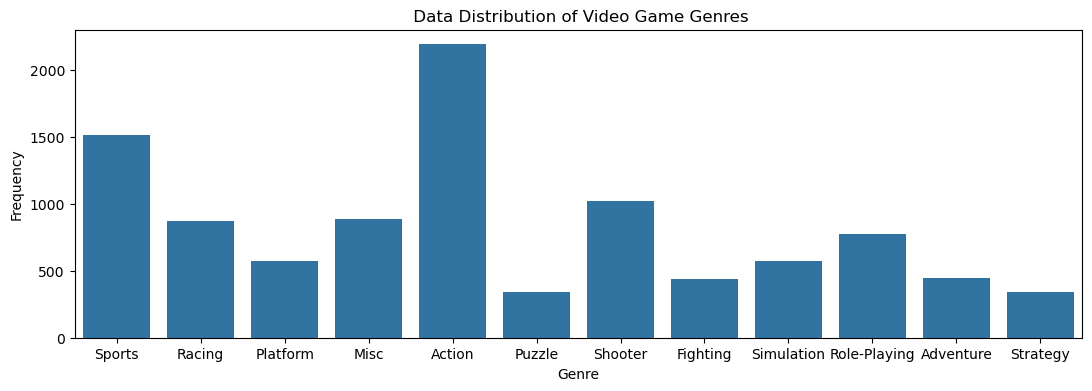

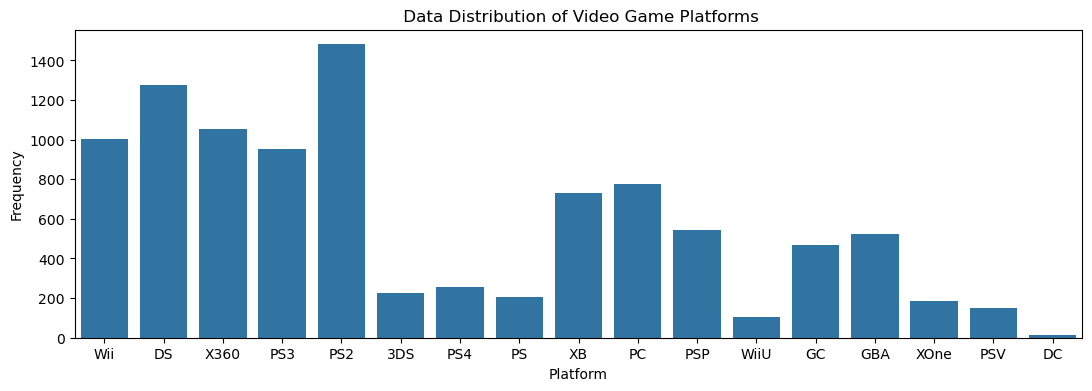

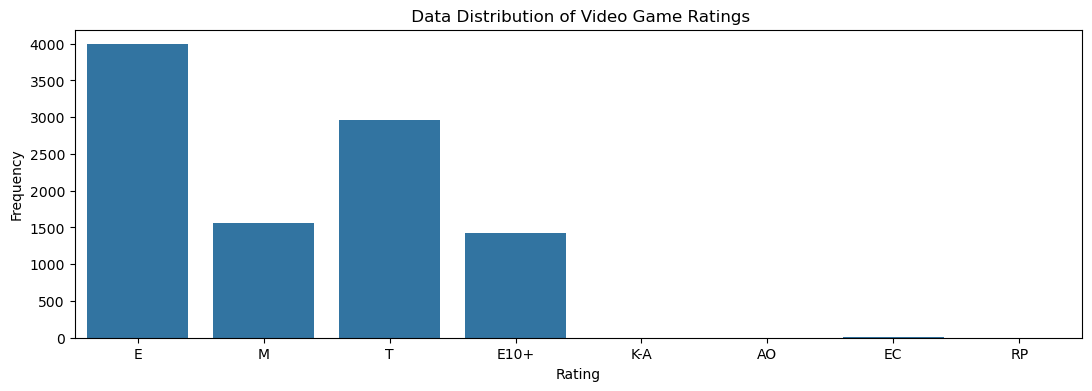

In [15]:
features = video_games_filtered_df[['Genre', 'Platform', 'Rating']].columns

for idx, feature in enumerate(features):
    plt.figure(figsize = (13,4))
    sns.countplot(data=video_games_filtered_df, x=feature)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(" Data Distribution of Video Game " + feature + "s")
plt.show()

In [16]:
# Replace 'tbd' value to NaN
video_games_filtered_df['User_Score'] = np.where(video_games_filtered_df['User_Score'] == 'tbd', 
                                                 np.nan, 
                                                 video_games_filtered_df['User_Score']).astype(float)

# Group the records by Genre, then aggregate them calculating the average of both Critic Score and User Score
video_game_grpby_genre = video_games_filtered_df[['Genre', 'Critic_Score', 'User_Score']].groupby('Genre', as_index=False)
video_game_score_mean = video_game_grpby_genre.agg(Ave_Critic_Score = ('Critic_Score', 'mean'), Ave_User_Score = ('User_Score', 'mean'))

# Merge the average scores with the main dataframe
video_games_filtered_df = video_games_filtered_df.merge(video_game_score_mean, on='Genre')
video_games_filtered_df

,Name,Platform,Genre,Critic_Score,User_Score,Rating,Ave_Critic_Score,Ave_User_Score
0,Wii Sports,Wii,Sports,76.0,8.0,E,72.037257,6.973126
1,Mario Kart Wii,Wii,Racing,82.0,8.3,E,67.927694,7.036767
2,Wii Sports Resort,Wii,Sports,80.0,8.0,E,72.037257,6.973126
3,New Super Mario Bros.,DS,Platform,89.0,8.5,E,68.058350,7.301402
4,Wii Play,Wii,Misc,58.0,6.6,E,66.650672,6.827460
...,...,...,...,...,...,...,...,...
9945,Bust-A-Move 3000,GC,Puzzle,53.0,NaN,E,67.418919,7.175000
9946,Mega Brain Boost,DS,Puzzle,48.0,NaN,E,67.418919,7.175000
9947,STORM: Frontline Nation,PC,Strategy,60.0,7.2,E10+,72.254296,7.320930
9948,Plushees,DS,Simulation,NaN,NaN,E,68.587896,7.136686


In [17]:
video_games_filtered_df['Critic_Score_Imputed'] = np.where(video_games_filtered_df['Critic_Score'].isna(), 
                                                           video_games_filtered_df['Ave_Critic_Score'], 
                                                           video_games_filtered_df['Critic_Score'])

video_games_filtered_df['User_Score_Imputed'] = np.where(video_games_filtered_df['User_Score'].isna(), 
                                                         video_games_filtered_df['Ave_User_Score'], 
                                                         video_games_filtered_df['User_Score'])
video_games_filtered_df

,Name,Platform,Genre,Critic_Score,User_Score,Rating,Ave_Critic_Score,Ave_User_Score,Critic_Score_Imputed,User_Score_Imputed
0,Wii Sports,Wii,Sports,76.0,8.0,E,72.037257,6.973126,76.000000,8.000000
1,Mario Kart Wii,Wii,Racing,82.0,8.3,E,67.927694,7.036767,82.000000,8.300000
2,Wii Sports Resort,Wii,Sports,80.0,8.0,E,72.037257,6.973126,80.000000,8.000000
3,New Super Mario Bros.,DS,Platform,89.0,8.5,E,68.058350,7.301402,89.000000,8.500000
4,Wii Play,Wii,Misc,58.0,6.6,E,66.650672,6.827460,58.000000,6.600000
...,...,...,...,...,...,...,...,...,...,...
9945,Bust-A-Move 3000,GC,Puzzle,53.0,NaN,E,67.418919,7.175000,53.000000,7.175000
9946,Mega Brain Boost,DS,Puzzle,48.0,NaN,E,67.418919,7.175000,48.000000,7.175000
9947,STORM: Frontline Nation,PC,Strategy,60.0,7.2,E10+,72.254296,7.320930,60.000000,7.200000
9948,Plushees,DS,Simulation,NaN,NaN,E,68.587896,7.136686,68.587896,7.136686


In [18]:
video_games_filtered_df[['Critic_Score', 'Critic_Score_Imputed', 'User_Score', 'User_Score_Imputed']].describe()

,Critic_Score,Critic_Score_Imputed,User_Score,User_Score_Imputed
count,8054.000000,9950.000000,7504.000000,9950.000000
mean,68.971319,68.851751,7.126879,7.107768
std,13.951640,12.594336,1.500750,1.305869
min,13.000000,13.000000,0.000000,0.000000
25%,60.000000,63.000000,6.400000,6.800000
50%,71.000000,69.000000,7.500000,7.136686
75%,79.000000,77.000000,8.200000,8.000000
max,98.000000,98.000000,9.700000,9.700000


In [19]:
video_games_final_df = video_games_filtered_df.drop(columns=['User_Score', 'Critic_Score', 'Ave_Critic_Score', 'Ave_User_Score'], axis=1)
video_games_final_df = video_games_final_df.reset_index(drop=True)

video_games_final_df = video_games_final_df.rename(columns={'Critic_Score_Imputed':'Critic_Score', 'User_Score_Imputed':'User_Score'})
video_games_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9950 entries, 0 to 9949
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          9950 non-null   object 
 1   Platform      9950 non-null   object 
 2   Genre         9950 non-null   object 
 3   Rating        9950 non-null   object 
 4   Critic_Score  9950 non-null   float64
 5   User_Score    9950 non-null   float64
dtypes: float64(2), object(4)
memory usage: 466.5+ KB


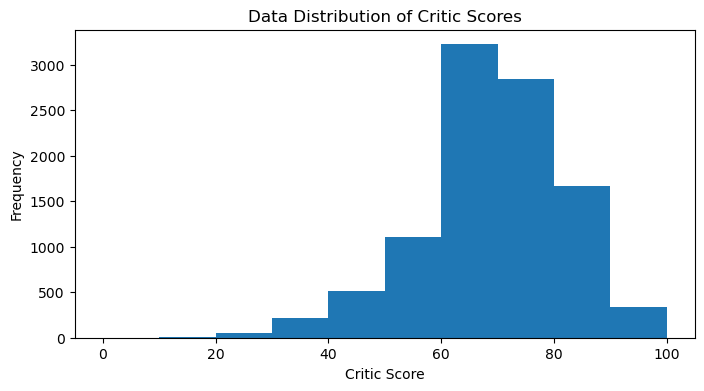

In [20]:
hist, bins = np.histogram(video_games_final_df['Critic_Score'], bins=10, range=(0, 100))

plt.figure(figsize = (8,4))
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]), align='edge')
plt.xlabel('Critic Score')
plt.ylabel('Frequency')
plt.title("Data Distribution of Critic Scores")
plt.show()

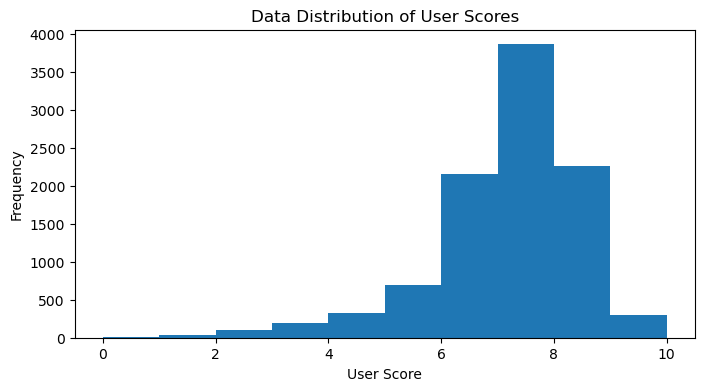

In [21]:
hist, bins = np.histogram(video_games_final_df['User_Score'], bins=10, range=(0, 10))

plt.figure(figsize = (8,4))
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]), align='edge')
plt.xlabel('User Score')
plt.ylabel('Frequency')
plt.title("Data Distribution of User Scores")
plt.show()

[Text(0.5, 0, 'User Score'),
 Text(0, 0.5, 'Critic Score'),
 Text(0.5, 1.0, 'User Scores vs. Critic Scores')]

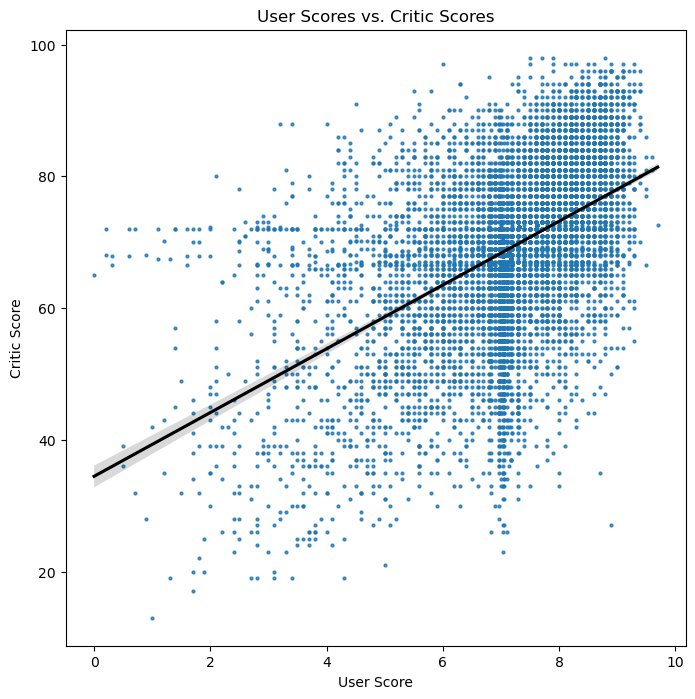

In [22]:
plt.figure(figsize=(8, 8))
ax = sns.regplot(x=video_games_final_df['User_Score'], y=video_games_final_df['Critic_Score'], 
                 line_kws={"color": "black"}, scatter_kws={'s': 4})
ax.set(xlabel ="User Score", ylabel = "Critic Score", title="User Scores vs. Critic Scores")

In [23]:
video_games_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9950 entries, 0 to 9949
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          9950 non-null   object 
 1   Platform      9950 non-null   object 
 2   Genre         9950 non-null   object 
 3   Rating        9950 non-null   object 
 4   Critic_Score  9950 non-null   float64
 5   User_Score    9950 non-null   float64
dtypes: float64(2), object(4)
memory usage: 466.5+ KB


In [24]:
categorical_columns = [name for name in video_games_final_df.columns if video_games_final_df[name].dtype=='O']
categorical_columns = categorical_columns[1:]

print(f'There are {len(categorical_columns)} categorical features:\n')
print(", ".join(categorical_columns))

There are 3 categorical features:

Platform, Genre, Rating


In [25]:
video_games_df_dummy = pd.get_dummies(data=video_games_final_df, columns=categorical_columns)
video_games_df_dummy.head(5)

,Name,Critic_Score,User_Score,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,...,Genre_Sports,Genre_Strategy,Rating_AO,Rating_E,Rating_E10+,Rating_EC,Rating_K-A,Rating_M,Rating_RP,Rating_T
0,Wii Sports,76.0,8.0,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False
1,Mario Kart Wii,82.0,8.3,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,Wii Sports Resort,80.0,8.0,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False
3,New Super Mario Bros.,89.0,8.5,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,Wii Play,58.0,6.6,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [26]:
video_games_df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9950 entries, 0 to 9949
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                9950 non-null   object 
 1   Critic_Score        9950 non-null   float64
 2   User_Score          9950 non-null   float64
 3   Platform_3DS        9950 non-null   bool   
 4   Platform_DC         9950 non-null   bool   
 5   Platform_DS         9950 non-null   bool   
 6   Platform_GBA        9950 non-null   bool   
 7   Platform_GC         9950 non-null   bool   
 8   Platform_PC         9950 non-null   bool   
 9   Platform_PS         9950 non-null   bool   
 10  Platform_PS2        9950 non-null   bool   
 11  Platform_PS3        9950 non-null   bool   
 12  Platform_PS4        9950 non-null   bool   
 13  Platform_PSP        9950 non-null   bool   
 14  Platform_PSV        9950 non-null   bool   
 15  Platform_Wii        9950 non-null   bool   
 16  Platfo

In [27]:
features = video_games_df_dummy.drop(columns=['Name'], axis=1)

scale = StandardScaler()
scaled_features = scale.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features, columns=features.columns)

scaled_features.head(5)

,Critic_Score,User_Score,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,Platform_PS2,...,Genre_Sports,Genre_Strategy,Rating_AO,Rating_E,Rating_E10+,Rating_EC,Rating_K-A,Rating_M,Rating_RP,Rating_T
0,0.567605,0.683282,-0.15314,-0.037537,-0.383200,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,2.365115,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
1,1.044034,0.913026,-0.15314,-0.037537,-0.383200,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,-0.422812,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
2,0.885224,0.683282,-0.15314,-0.037537,-0.383200,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,2.365115,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
3,1.599867,1.066188,-0.15314,-0.037537,2.609607,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,-0.422812,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
4,-0.861681,-0.388855,-0.15314,-0.037537,-0.383200,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,-0.422812,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896


In [28]:
model = NearestNeighbors(n_neighbors=11, metric='cosine', algorithm='brute').fit(scaled_features)
print(model)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=11)


In [29]:
vg_distances, vg_indices = model.kneighbors(scaled_features)

print("List of indexes and distances for the first 5 games:\n")
print(vg_indices[:5], "\n")
print(vg_distances[:5])

List of indexes and distances for the first 5 games:

[[   0 3228 3812 1091    2 3555 2812    7 1635 3314 1062]
 [   1 4447 2648 3818 3200 5731 3291 2917 4782 1660 7624]
 [   2 2812 1091    7 1635    0 3228 2741 4139 1170 2595]
 [   3 1989 1435  310 8036 1210 1059 3986 7920 4218  384]
 [   4 3333   54 3101 5314  991  208  650 5178 7952 4432]] 

[[0.00000000e+00 1.45719262e-04 7.95959057e-04 1.52363383e-03
  2.48420244e-03 2.76264905e-03 3.85590684e-03 3.90039612e-03
  4.56853634e-03 4.76778616e-03 4.88365814e-03]
 [1.11022302e-16 4.12331472e-03 1.25114932e-02 1.79102267e-02
  1.83496406e-02 2.76557305e-02 2.76557305e-02 3.40316310e-02
  3.42846867e-02 3.53362240e-02 4.36579924e-02]
 [1.11022302e-16 1.50397540e-04 3.04331263e-04 1.30700527e-03
  2.23694972e-03 2.48420244e-03 2.65392852e-03 2.71666441e-03
  3.38307214e-03 3.38307214e-03 3.43195161e-03]
 [2.22044605e-16 1.60977583e-03 3.62042660e-03 4.76682680e-03
  1.20358234e-02 1.27341263e-02 1.30603498e-02 1.37578769e-02
  1.60735434e

In [30]:
game_names = video_games_df_dummy['Name'].drop_duplicates()
game_names = game_names.reset_index(drop=True)

vectorizer = TfidfVectorizer(use_idf=True).fit(game_names)
print(vectorizer)

TfidfVectorizer()


In [31]:
game_title_vectors = vectorizer.transform(game_names)

print("List of game title vectors for the first 5 games:\n")
print(pd.DataFrame(game_title_vectors.toarray()).head(5))

List of game title vectors for the first 5 games:

   0     1     2     3     4     5     6     7     8     9     ...  4812  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

   4813  4814  4815  4816  4817  4818  4819  4820  4821  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 4822 columns]


In [47]:
def VideoGameTitleRecommender(video_game_name):
    '''
    This function will recommend a game title that has the closest match to the input
    '''
    query_vector = vectorizer.transform([video_game_name])
    similarity_scores = cosine_similarity(query_vector, game_title_vectors)

    closest_match_index = similarity_scores.argmax()
    closest_match_game_name = game_names[closest_match_index]

    return closest_match_game_name


def VideoGameRecommender(video_game_name, video_game_platform='Any'):
    '''
    This function will provide game recommendations based on various features of the game
    '''
    default_platform = 'Any'

    # User input: Game Title and Platform
    if video_game_platform != default_platform:
        video_game_idx = video_games_final_df.query("Name == @video_game_name & Platform == @video_game_platform").index
        
        if video_game_idx.empty:
            video_game_idx = video_games_final_df.query("Name == @video_game_name").index

            if not video_game_idx.empty:
                print(f"Note: Recommendations will be based on the title of the game as it is not available on the specified platform.\n")
                video_game_platform = default_platform
    
    # User input: Game Title only
    else:
        video_game_idx = video_games_final_df.query("Name == @video_game_name").index  
    
    if video_game_idx.empty:
        # If the game entered by the user doesn't exist in the records, the program will recommend a new game similar to the input
        closest_match_game_name = VideoGameTitleRecommender(video_game_name)

        print(f"'{video_game_name}' doesn't exist in the records.\n")
        print(f"You may want to try '{closest_match_game_name}', which is the closest match to the input.")
    
    else:
        # User input: Game Title only
        if video_game_platform == default_platform:

            # Place in a separate dataframe the indices and distances, then sort the record by distance in ascending order       
            vg_combined_dist_idx_df = pd.DataFrame()
            for idx in video_game_idx:
                # Remove from the list any game that shares the same name as the input
                vg_dist_idx_df = pd.concat([pd.DataFrame(vg_indices[idx][1:]), pd.DataFrame(vg_distances[idx][1:])], axis=1)
                vg_combined_dist_idx_df = pd.concat([vg_combined_dist_idx_df, vg_dist_idx_df])

            vg_combined_dist_idx_df = vg_combined_dist_idx_df.set_axis(['Index', 'Distance'], axis=1)

            vg_combined_dist_idx_df = vg_combined_dist_idx_df.reset_index(drop=True)
            vg_combined_dist_idx_df = vg_combined_dist_idx_df.sort_values(by='Distance', ascending=True)

            video_game_list = video_games_final_df.iloc[vg_combined_dist_idx_df['Index']]

            # Remove any duplicate game names to provide the user with a diverse selection of recommended games
            video_game_list = video_game_list.drop_duplicates(subset=['Name'], keep='first')
            
            # Get the first 10 games in the list
            video_game_list = video_game_list.head(15)

            # Get the distance of the games similar to the input
            recommended_distances = np.array(vg_combined_dist_idx_df['Distance'].head(15))

        # User input: Game Title and Platform
        else:
            # Remove from the list any game that shares the same name as the input
            recommended_idx = vg_indices[video_game_idx[0]][1:]
            video_game_list = video_games_final_df.iloc[recommended_idx]

            # Get the distance of the games similar to the input
            recommended_distances = np.array(vg_distances[video_game_idx[0]][1:])

        print(f"Top 10 Recommended Video Games for '{video_game_name}' [platform:{video_game_platform}]")

        video_game_list = video_game_list.reset_index(drop=True)
        recommended_video_game_list = pd.concat([video_game_list, 
                                                 pd.DataFrame(recommended_distances, columns=['Similarity_Distance'])], axis=1)

        display(recommended_video_game_list.style.set_properties(**{'index': False}))

In [53]:
VideoGameRecommender('Metro 2033')

Top 10 Recommended Video Games for 'Crysis: Warhead' [platform:Any]


,Name,Platform,Genre,Rating,Critic_Score,User_Score,Similarity_Distance
0,Titanfall 2,PC,Shooter,M,85.000000,8.000000,0.000183
1,Unreal Tournament III,PC,Shooter,M,83.000000,8.000000,0.000195
2,Bulletstorm,PC,Shooter,M,82.000000,7.700000,0.000754
3,Doom,PC,Shooter,M,85.000000,8.200000,0.000906
4,Gears of War,PC,Shooter,M,87.000000,7.800000,0.000960
5,Borderlands,PC,Shooter,M,81.000000,7.800000,0.000968
6,Unreal Tournament 2003,PC,Shooter,M,86.000000,8.200000,0.001170
7,Painkiller,PC,Shooter,M,81.000000,8.100000,0.001283
8,Metro 2033,PC,Shooter,M,81.000000,8.100000,0.001283
9,BioShock 2,PC,Shooter,M,88.000000,8.000000,0.001574
